# Credit Card Fraud Detection

In this notebook we will attempt to predict credit card fraud in this [kaggle dataset](https://www.kaggle.com/mlg-ulb/creditcardfraud/data)

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from plotnine import *
%matplotlib inline

First let's import the data and check it out

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
data.isnull().sum().sum()

0

We can see there are no null values. Almost all the columns are anonomyous so feature engineering becomes tricky. As per the kaggle description, in fact these are 28 principle components following PCA prepropcessing. There's a time label corresponding to seconds over 2 days, an amount label that corresponds to the charge amount, and the class - fraudulent (1) or not (0).

Let's see what we can learn about what we are trying to predict. I'll first make a train test split.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], data.Class, test_size=0.25, random_state=1)
training_data = pd.concat([X_train, y_train], axis = 1)

In [6]:
outcomes = y_train.value_counts() 
print('only {} % of the observations are fraud'.format(outcomes[1]/outcomes[0]*100))

only 0.17868532622969271 % of the observations are fraud


The first thing to note is that we have MAJOR class imbalance. One way to deal with this is to upsample the under-represented class. We can also adjust the cost function in sklearn such that costs of incorrect answers in the underrepresented class are weighted in proportion to how underepresentized that class in. Finally, we can use algorithms that perform better with class imbalance like decision trees. But before I get there lets glance through our data.

The time label is actually the seconds after data collection begins so we can make some features out of this.

In [7]:
print('Number of total days: {}'.format(X_train.Time.max()/(3600*24)))

Number of total days: 1.9999074074074075


There's only 2 actual days here so I suppose it makes most sense to break this down into hours.

In [8]:
X_train['Hour'] = np.ceil(data.Time/3600) % 24
X_test['Hour'] = np.ceil(data.Time/3600) % 24
training_data['Hour'] = np.ceil(data.Time/3600) % 24

In [64]:
X_train.drop('Time',inplace=True,axis=1)
X_test.drop('Time',inplace=True,axis = 1)
training_data.drop('Time',inplace=True, axis = 1)

Let's see what we can learn looking through hour.

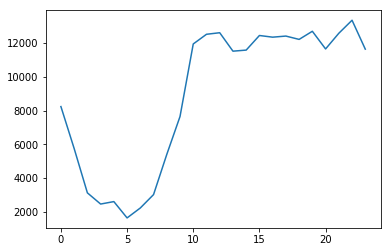

In [9]:
training_data.Hour.value_counts().sort_index().plot()

For one thing we can see that the number of observations clearly varies with time. It appears that there are way less credit card usages after midnight. But what about the fraud instances?

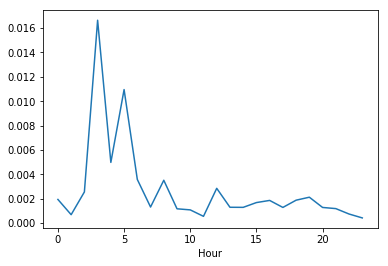

In [11]:
training_data.groupby('Hour').Class.mean().plot()

It seems that hour is an informative feature, and that fraud rate relative to the total number of transactions spikes between 1 and 5 am, in general.

Since this data is PCA data we can check out the proportion of total variance explained by each feature

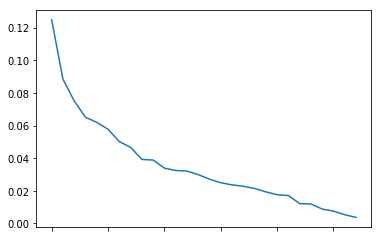

In [44]:
variances = (training_data.loc[:,'V1':'V28'].describe().loc[['std'],:]**2).T
variances = variances/variances.sum()
variances.plot(legend = False)

We can see there's no clear cutoff point where new variables stop capturing information.

I'm also curious if the 'amount' feature is important.

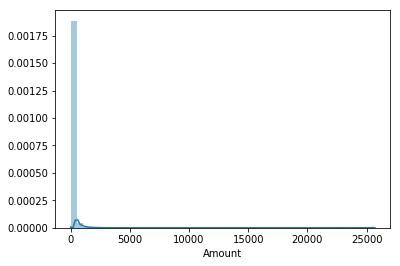

In [60]:
sns.distplot(training_data.Amount) 

There are a small amount of really large transactions here,I'll use log scaling to make them more viewable, and also we can look at the distributions for legit and fraud transactions.

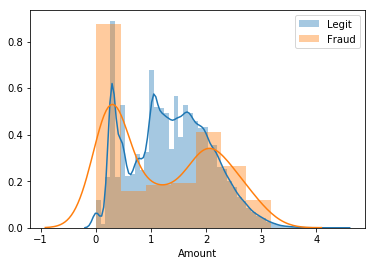

In [113]:
sns.distplot(np.log10(training_data.Amount[training_data.Class == 0]+1),label = 'Legit')
sns.distplot(np.log10(training_data.Amount[training_data.Class == 1]+1), label = 'Fraud')
plt.legend()

Both distributions are obviously bimodal. It does seem like the fraud transactions have a dip in the middle region compared to the legit transactions, ie. the transactions are either really inexpensive or over $100. The far extreme - really expensive transactions that barely appear on this graph, are mostly legit transactions.

We can also visualize the distributions amongst all of the principle components

In [119]:
value_vars = [col for col in training_data.columns if col not in ['Class','Amount','Hour']]
long_table = training_data.melt(value_vars=value_vars,id_vars='Class')

In [120]:
long_table.head()

,Class,variable,value
0,0,V1,-0.459482
1,0,V1,1.878563
2,0,V1,-1.467414
3,0,V1,2.073474
4,0,V1,1.097497


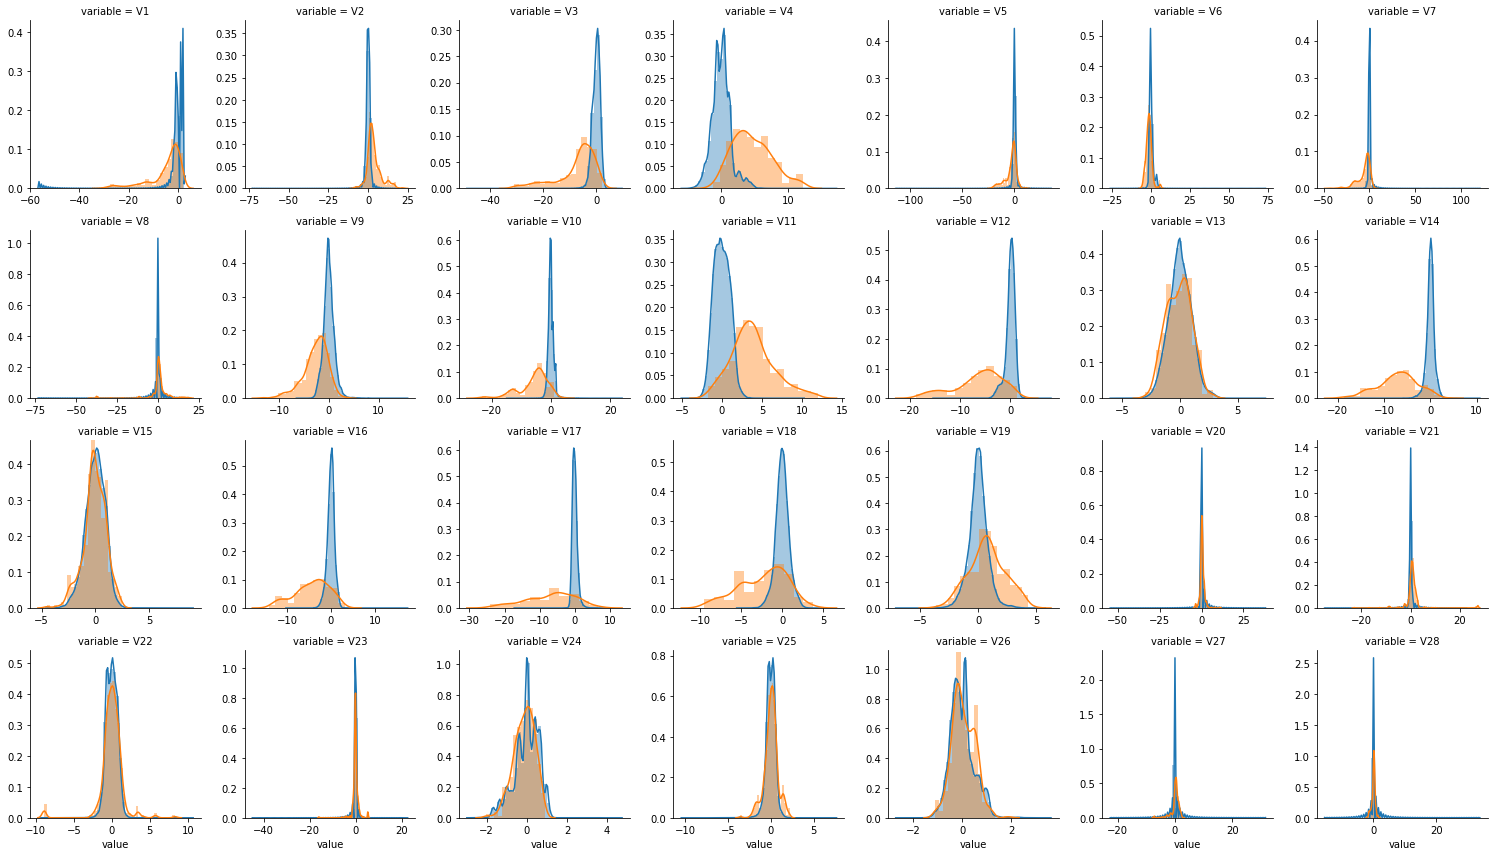

In [123]:
g = sns.FacetGrid(data = long_table, col='variable', col_wrap = 7, hue = 'Class',sharex = False, sharey=False)
g.map(sns.distplot, "value")

Neat! We can see some clear seperation in distributions for some of the components. Otherse seem to matter less. Note that it appears that the most important components are not necessarily the ones that capture the most variation in the original dataset. I'm tempted to try and remove some features that look poorly performing, such as V27 and V28, but using regularization and ensemble methods we should perform well without reducing the data further.

In the end we can let the model decide what features are important, particularly since this is just unlabeled PCA data with no information on the component loadings.

In [205]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.model_selection import GridSearchCV

I'll start off with logistic regression, using cross validation to tune an L1 penalty.

In [193]:
tuning_grid = {'C':[.001,.01,.1,1,10,100,1000]}
logistic_mod = LogisticRegression(penalty = 'l1',
                                  class_weight='balanced' # this imparts harsher penalties 
                                                          # for getting the underrepresented class wrong
                                 )

In [194]:
logistic_cv = GridSearchCV(logistic_mod,param_grid=tuning_grid,n_jobs = -1, 
                           scoring = 'average_precision',cv = 5,return_train_score=False)

In [195]:
logistic_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
       scoring='average_precision', verbose=0)

In [196]:
pd.DataFrame(logistic_cv.cv_results_).loc[:,['mean_test_score','param_C']]

,mean_test_score,param_C
0,0.741274,0.001
1,0.758277,0.01
2,0.763138,0.1
3,0.762410,1
4,0.762499,10
5,0.762642,100
6,0.762620,1000


In [270]:
preds = logistic_cv.predict(X_test)
print(classification_report(y_test, preds))
print('\n')
print(confusion_matrix(y_test, preds))

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     71091
          1       0.07      0.88      0.13       111

avg / total       1.00      0.98      0.99     71202



[[69794  1297]
 [   13    98]]


Precision Recall Area Under Curve: 0.6943987299768858


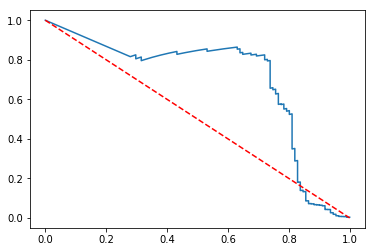

In [199]:
pred_proba = logistic_cv.predict_proba(X_test)
precision,recall,_ = precision_recall_curve(y_test,pred_proba[:,1])
print('Precision Recall Area Under Curve: {}'.format(auc(recall, precision)))
plt.plot(recall,precision)
plt.plot([0,1],[1,0],'r--')

Our logistic regression model is clearly imperfect.  It has great recall but a large amount of false positives. I'll next try a Random Forest.

In [86]:
rfmod = RandomForestClassifier(class_weight='balanced' # this imparts harsher penalties for getting the underrepresented class wrong
                               ,n_estimators= 500)

In [87]:
rfmod.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [267]:
preds = rfmod.predict(X_test)

In [268]:
print(classification_report(y_test, preds))
print('\n')
print(confusion_matrix(y_test, preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71091
          1       0.94      0.75      0.83       111

avg / total       1.00      1.00      1.00     71202



[[71086     5]
 [   28    83]]


In [201]:
pred_proba = rfmod.predict_proba(X_test)
precision,recall,_ = precision_recall_curve(y_test,pred_proba[:,1])

Precision Recall Area Under Curve: 0.8113781722057999


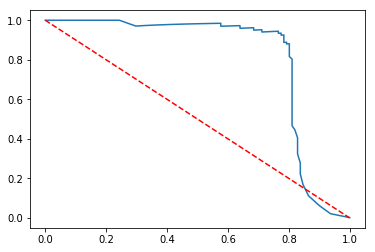

In [202]:
print('Precision Recall Area Under Curve: {}'.format(auc(recall, precision)))
plt.plot(recall,precision)
plt.plot([0,1],[1,0],'r--')

Pretty good, especially for no tuning at all. Hurray for Random Forests! False positives are quite rare with this model, but we do miss 25% of positives. As the precision recall curve indicates, there is no way for this model to get above 80% recall without major sacrifices to precision.

Finally, I'll try an adaboost model.

In [206]:
adamod = AdaBoostClassifier(n_estimators=1000, learning_rate = .1, base_estimator=DecisionTreeClassifier(max_depth = 3)
                           ) # adaboost iteratively reweights on it's own to try and predict things it got wrong

In [207]:
adamod.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.1, n_estimators=1000, random_state=None)

In [209]:
preds = adamod.predict(X_test)
print(classification_report(y_test, preds))
print('\n')
print(confusion_matrix(y_test, preds))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     71091
          1       0.97      0.76      0.85       111

avg / total       1.00      1.00      1.00     71202



[[71088     3]
 [   27    84]]


Precision Recall Area Under Curve: 0.7930270867657185


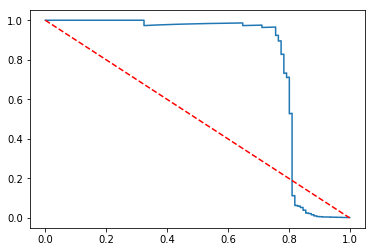

In [208]:
pred_proba = adamod.predict_proba(X_test)
precision,recall,_ = precision_recall_curve(y_test,pred_proba[:,1])
print('Precision Recall Area Under Curve: {}'.format(auc(recall, precision)))
plt.plot(recall,precision)
plt.plot([0,1],[1,0],'r--')

This might be able to be optimized more since I didn't tune anything, but the general trend is similar but slightly better than  random forests. Again there is a limitation on stretching recall past 0.8 or so.

We can also look at what features are important across our models.

In [272]:
logistic_coef = abs(logistic_cv.best_estimator_.coef_[0])/sum(abs(logistic_cv.best_estimator_.coef_[0])) 
# this isn't quite right for logistic regression since not all the features are scaled here but I don't feel like remaking the models :)

In [261]:
variable_importance = pd.DataFrame([rfmod.feature_importances_,adamod.feature_importances_, logistic_coef]).T
variable_importance.index = X_train.columns
variable_importance.columns = ['RF_Var_Imp','Ada_Var_Imp','Logistic_Reg']

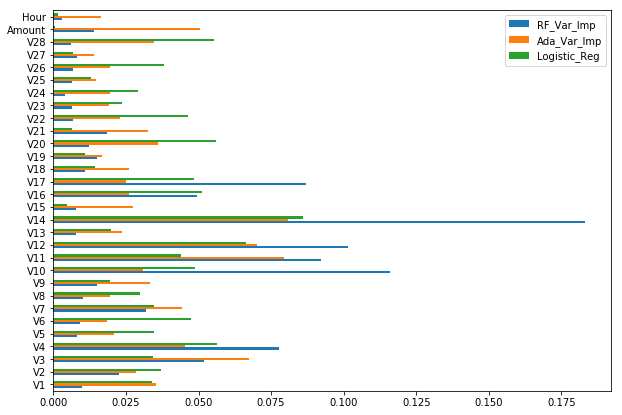

In [262]:
variable_importance.plot.barh(figsize = (10,7))

We can see there are definitely some similarities across the models in terms of which features are valued, though the relative importance of each feature does vary. Some options now are to eliminate less useful features and see if it helps reduce overfitting, tune hyperparameters, see if an ensemble of predictive models helps improve our metrics, try other model types, etc.

The correct model will depend on the goals. Do we need to catch every instance of fraud? How acceptable are false positives? I think the random forest and adaboost mods here strike a good balance, but on the other hand, if our goal is to find every instance of fraud without worrying about having low precision, there will be better models, such as the logistic regression model which achieved high recall at the cost of precision.